# Project - MIlkyway model
gala provides a simple mass model for the Milky Way based on recent measurements of the enclosed mass compiled from the literature. See the Defining a Milky Way potential model documentation for more information about how this model was defined.

In this example, we will use the position and velocity and uncertainties of the Milky Way satellite galaxy “Draco” to integrate orbits in a Milky Way mass model starting from samples from the error distribution over initial conditions defined by its observed kinematics. We will then compute distributions of orbital properties like orbital period, pericenter, and eccentricity.

Let’s start by importing packages we will need:

In [1]:
# Third-party
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np

# Gala
import gala.dynamics as gd
import gala.potential as gp

In [2]:
coord.galactocentric_frame_defaults.set('v4.0');

In [3]:
potential = gp.MilkyWayPotential()


In [6]:
icrs = coord.SkyCoord(
    ra=coord.Angle('17h 20m 12.4s'),
    dec=coord.Angle('+57° 54′ 55″'),
    distance=76*u.kpc,
    pm_ra_cosdec=0.0569*u.mas/u.yr,
    pm_dec=-0.1673*u.mas/u.yr,
    radial_velocity=-291*u.km/u.s)

icrs_err = coord.SkyCoord(
    ra=0*u.deg,
    dec=0*u.deg,
    distance=6*u.kpc,
    pm_ra_cosdec=0.009*u.mas/u.yr,
    pm_dec=0.009*u.mas/u.yr,
    radial_velocity=0.1*u.km/u.s)

In [5]:
galcen_frame = coord.Galactocentric()
galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [7]:
galcen = icrs.transform_to(galcen_frame)

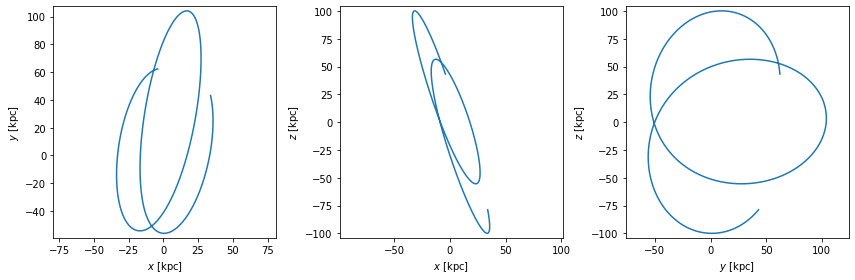

In [8]:
w0 = gd.PhaseSpacePosition(galcen.data)
orbit = potential.integrate_orbit(w0, dt=-0.5*u.Myr, n_steps=10000)
fig = orbit.plot()


In [9]:
orbit.pericenter(), orbit.apocenter(), orbit.eccentricity()


(<Quantity 45.47408489 kpc>,
 <Quantity 105.60902722 kpc>,
 <Quantity 0.39802557>)

Text(0, 0.5, '$r$ [$\\mathrm{kpc}$]')

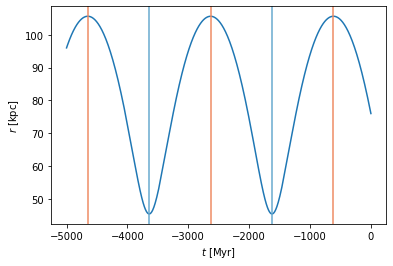

In [10]:
plt.plot(orbit.t, orbit.spherical.distance, marker='None')

per, per_times = orbit.pericenter(return_times=True, func=None)
apo, apo_times = orbit.apocenter(return_times=True, func=None)

for t in per_times:
    plt.axvline(t.value, color='#67a9cf')

for t in apo_times:
    plt.axvline(t.value, color='#ef8a62')

plt.xlabel('$t$ [{0}]'.format(orbit.t.unit.to_string('latex')))
plt.ylabel('$r$ [{0}]'.format(orbit.x.unit.to_string('latex')))

In [11]:
n_samples = 128

dist = np.random.normal(icrs.distance.value, icrs_err.distance.value,
                        n_samples) * icrs.distance.unit

pm_ra_cosdec = np.random.normal(icrs.pm_ra_cosdec.value,
                                icrs_err.pm_ra_cosdec.value,
                                n_samples) * icrs.pm_ra_cosdec.unit

pm_dec = np.random.normal(icrs.pm_dec.value,
                          icrs_err.pm_dec.value,
                          n_samples) * icrs.pm_dec.unit

rv = np.random.normal(icrs.radial_velocity.value,
                      icrs_err.radial_velocity.value,
                      n_samples) * icrs.radial_velocity.unit

ra = np.full(n_samples, icrs.ra.degree) * u.degree
dec = np.full(n_samples, icrs.dec.degree) * u.degree

In [14]:
icrs_samples = coord.SkyCoord(ra=ra, dec=dec, distance=dist,
                              pm_ra_cosdec=pm_ra_cosdec,
                              pm_dec=pm_dec, radial_velocity=rv)

In [15]:
icrs_samples.shape


(128,)

In [16]:
galcen_samples =icrs_samples.transform_to(galcen_frame)

In [17]:
w0_samples = gd.PhaseSpacePosition(galcen_samples.data)
orbit_samples = potential.integrate_orbit(w0_samples, dt=-1*u.Myr, n_steps=4000)


In [18]:
orbit_samples.shape


(4001, 128)

In [19]:
peris = orbit_samples.pericenter(approximate=True)

apos = orbit_samples.apocenter(approximate=True)

eccs = orbit_samples.eccentricity(approximate=True)

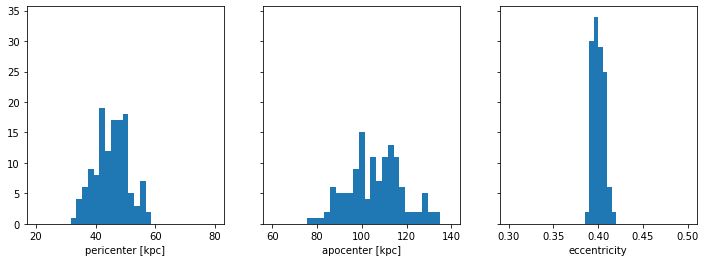

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(peris.to_value(u.kpc), bins=np.linspace(20, 80, 32))
axes[0].set_xlabel('pericenter [kpc]')

axes[1].hist(apos.to_value(u.kpc), bins=np.linspace(60, 140, 32))
axes[1].set_xlabel('apocenter [kpc]')

axes[2].hist(eccs.value, bins=np.linspace(0.3, 0.5, 41))
axes[2].set_xlabel('eccentricity');